<h1>OpenRice Data Analyse</h1>
<h2> Part 4 - Predicting Popularity by ML</h2>
Using Name of Bookmark as indicator of popularity, predicting using XG Boost

<h2>Step 1: Features Engineering</h2>

In [137]:
import pandas as pd
import mysql.connector
from sklearn.preprocessing import MultiLabelBinarizer 
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [138]:
%matplotlib inline

In [139]:
# Set up database connection parameters
config = {
    'user': 'root',
    'password': '{password}',
    'host': 'localhost',
    'database': 'openrice'
}

# Create a connection object
cnx = mysql.connector.connect(**config)

In [140]:
sql = '''
SELECT restaurant_id, bookmark, price, cuisine_clean, dish_clean, emoji_smile, emoji_ok, emoji_cry, review_cnt, photo_cnt, datediff(update_date, latest_review) as date_gap_since_latest_review
FROM OPENRICE.PUBLISH_RESTAURANTS
where bookmark is not null
'''
df = pd.read_sql(sql,cnx)

In [141]:
cnx.close()

In [142]:
df['cuisine_clean'] = df['cuisine_clean'].fillna('')
df['dish_clean'] = df['dish_clean'].fillna('')
mlb = MultiLabelBinarizer()
cuisine_dummies = pd.DataFrame(mlb.fit_transform(df['cuisine_clean'].str.split('/')), columns=[f'cuisine_{c}' for c in mlb.classes_])
dish_dummies = pd.DataFrame(mlb.fit_transform(df['dish_clean'].str.split('/')), columns=[f'dish_{d}' for d in mlb.classes_])
df = pd.concat([df, cuisine_dummies, dish_dummies], axis=1)
df.drop(['cuisine_clean', 'dish_clean','cuisine_','dish_'], axis=1, inplace=True)

In [143]:
# Fill in missing values in the date_gap_since_latest_review column
df['date_gap_since_latest_review'].fillna(9999, inplace=True)
price_mapper = {"Below $50":1,'$51-100':2,'$101-200':3,'$201-400':4,'$401-800':5,'Above $801':6}
df.drop('restaurant_id', axis=1,inplace = True)
df['price'] = df['price'].replace(price_mapper)

In [144]:
df.isnull().values.any()

False

In [145]:
df.head()

,bookmark,price,emoji_smile,emoji_ok,emoji_cry,review_cnt,photo_cnt,date_gap_since_latest_review,cuisine_1001,cuisine_1002,...,dish_1085,dish_1086,dish_1200,dish_1201,dish_1202,dish_1203,dish_1204,dish_1205,dish_1206,dish_1302
0,1142.0,4,27.0,0.0,2.0,35.0,336.0,11.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16.0,1,0.0,0.0,0.0,0.0,0.0,9999.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3042.0,1,72.0,5.0,0.0,91.0,528.0,33.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1193.0,4,4.0,1.0,0.0,6.0,57.0,13.0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,50.0,3,0.0,0.0,0.0,0.0,18.0,9999.0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h2>Step 2: Model Training</h2>

In [91]:
df_rel = df[['bookmark', 'price', 'emoji_smile', 'emoji_ok', 'emoji_cry',
       'review_cnt', 'photo_cnt', 'date_gap_since_latest_review']]

<AxesSubplot:>

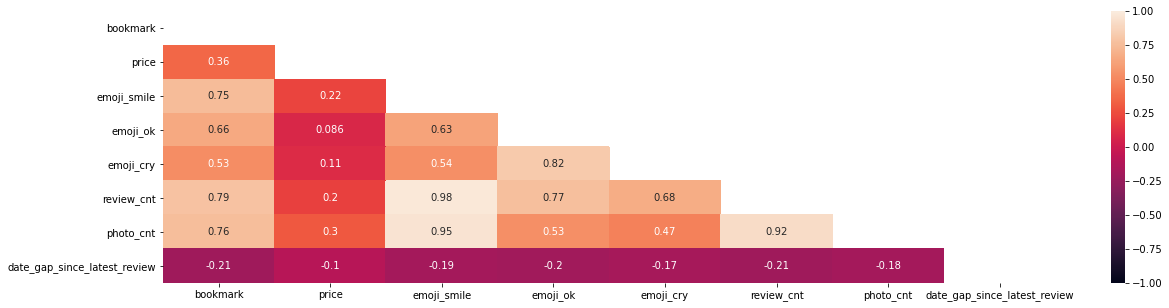

In [92]:
plt.figure(figsize=(20,5))
mask = np.triu(np.ones_like(df_rel.corr(), dtype=np.bool))
sns.heatmap(df_rel.corr(), vmin=-1, vmax=1, annot=True, mask=mask)

In [146]:
X = df.drop('bookmark', axis=1)
y = df['bookmark']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
param_grid = {
    'learning_rate': [1,0.1,0.01],
    'max_depth': [3,4,5],
    'n_estimators': [100,300,500],
    'gamma': [0,0.25,1]
}

xgb = XGBRegressor()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [149]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
Best score: 0.7691764648044993


In [150]:
best_xgb = XGBRegressor(**grid_search.best_params_)
best_xgb.fit(X_train, y_train)

# Evaluate the model on the test set
score = best_xgb.score(X_test, y_test)
print('Score:', score)

Score: 0.7721583855069629


In [164]:
best_xgb.feature_importances_


array([0.02883017, 0.03120176, 0.07051582, 0.01451223, 0.17976552,
       0.3167238 , 0.00974804, 0.        , 0.01405393, 0.00033886,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00349454, 0.00442748,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00773946, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00629785, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02236461, 0.        , 0.        , 0.00537983,
       0.00863497, 0.00458199, 0.        , 0.00568542, 0.        ,
       0.        , 0.        , 0.00928196, 0.        , 0.        ,
       0.        , 0.00723964, 0.        , 0.00849804, 0.        ,
       0.        , 0.        , 0.01390097, 0.        , 0.01920234,
       0.        , 0.01258369, 0.        , 0.02313029, 0.00508

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

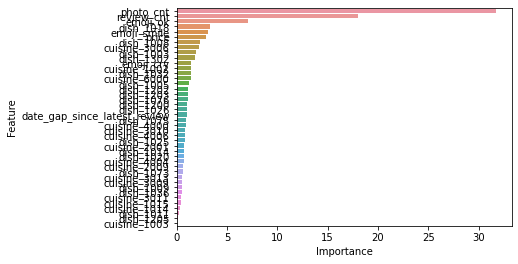

In [155]:
featureImp= []
for feat, importance in zip(X_train.columns, best_xgb.feature_importances_):  
    if importance > 0:
        temp = [feat, importance*100]
        featureImp.append(temp)
model_df = pd.DataFrame(featureImp,columns = ['Feature', 'Importance']).sort_values('Importance', ascending = False)
sns.barplot(x=model_df['Importance'], y=model_df['Feature'])

In [160]:
model_df.head(10)

,Feature,Importance
5,photo_cnt,31.672379
4,review_cnt,17.976552
2,emoji_ok,7.051582
28,dish_1018,3.293080
1,emoji_smile,3.120176
0,price,2.883017
24,dish_1008,2.313029
13,cuisine_3006,2.236461
22,dish_1003,1.920234
41,dish_1302,1.822011


<h2>Step 3: Save the Model</h2>

In [168]:
best_xgb.save_model('./xgb_model.json')

In [171]:
xgb_model = XGBRegressor()
xgb_model.load_model("./xgb_model.json")

In [180]:
xgb_model.predict(df.drop('bookmark', axis=1).iloc[300:310])

array([  179.45142,  2657.3733 ,  1354.785  , 15795.165  ,  4285.4297 ,
         320.2122 ,  6435.9937 ,  7965.759  ,  3367.5315 ,   165.98122],
      dtype=float32)